In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
from mriqc.viz.misc import (
    raters_variability_plot, plot_abide_stripplots, plot_corrmat, plot_histograms, figure1
)

data_path = '/home/oesteban/Google Drive/mriqc'

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:

x_path = op.join(data_path, 'aMRIQC_abide_20161130.csv')
# y_path = op.join(data_path, 'ABIDE_QC_Marie.csv')
y_path = op.join(data_path, 'ABIDE_QC_all.csv')

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nilearn/image/resampling.py:472: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


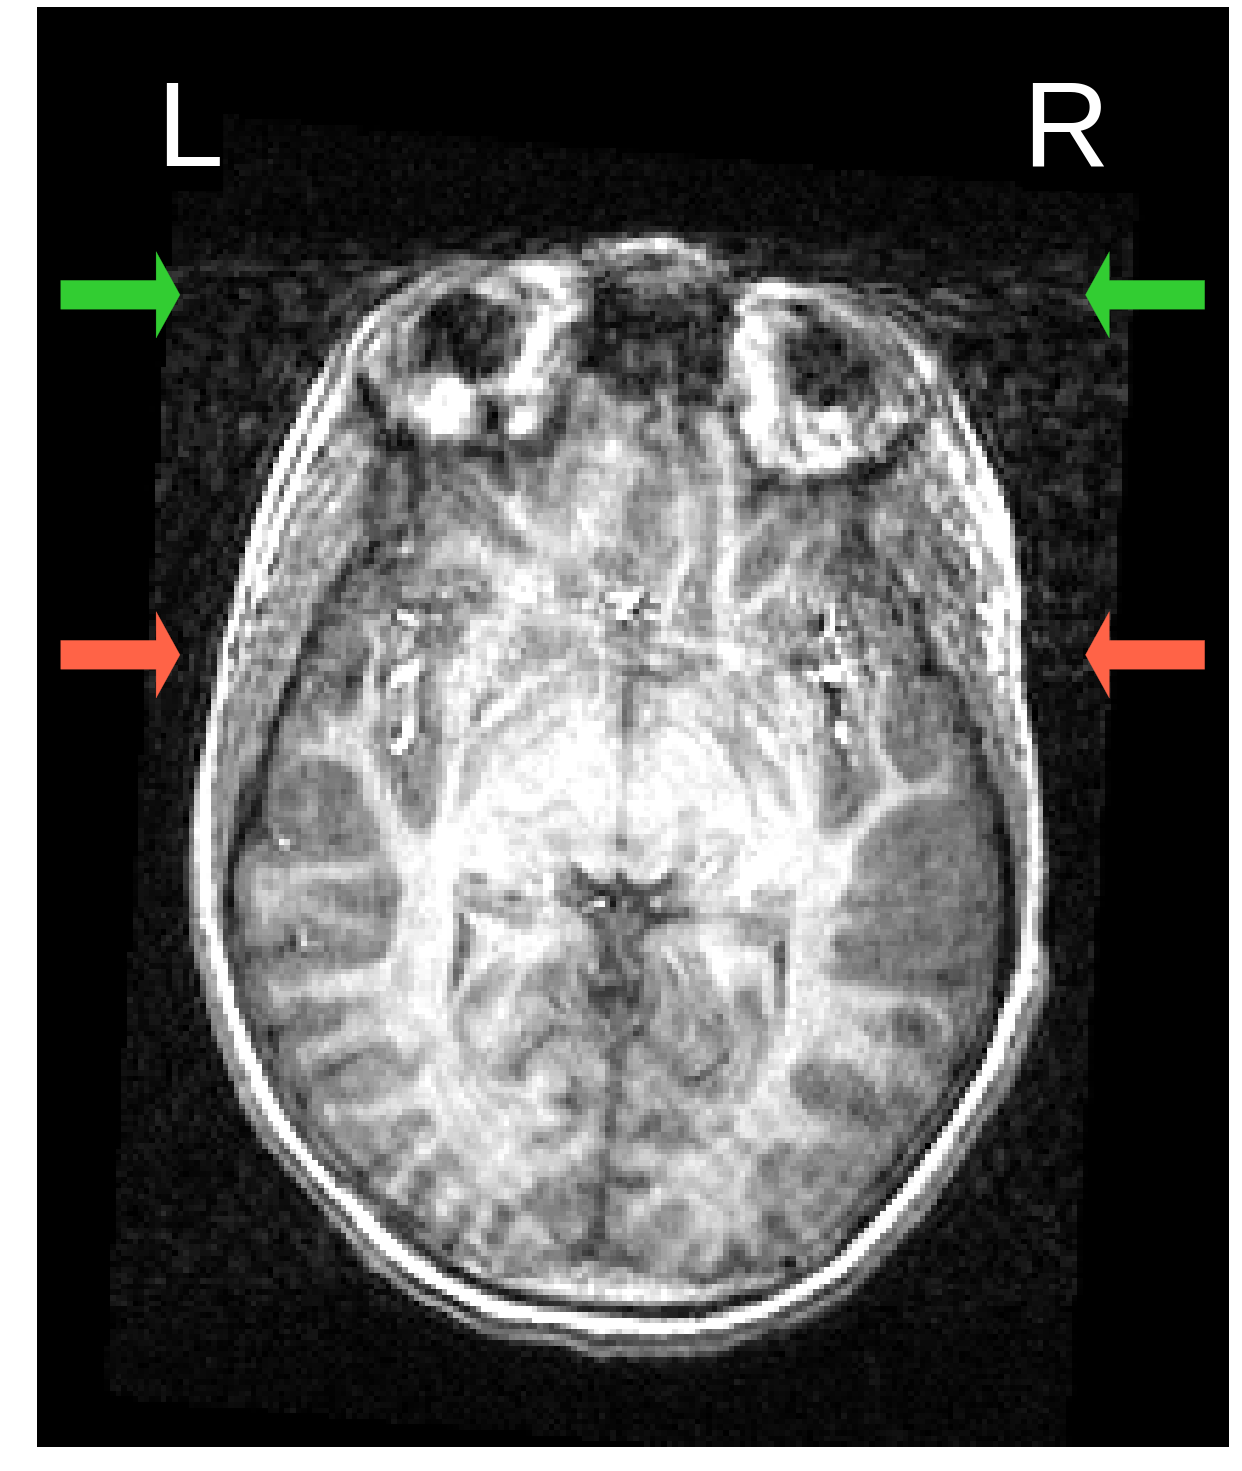

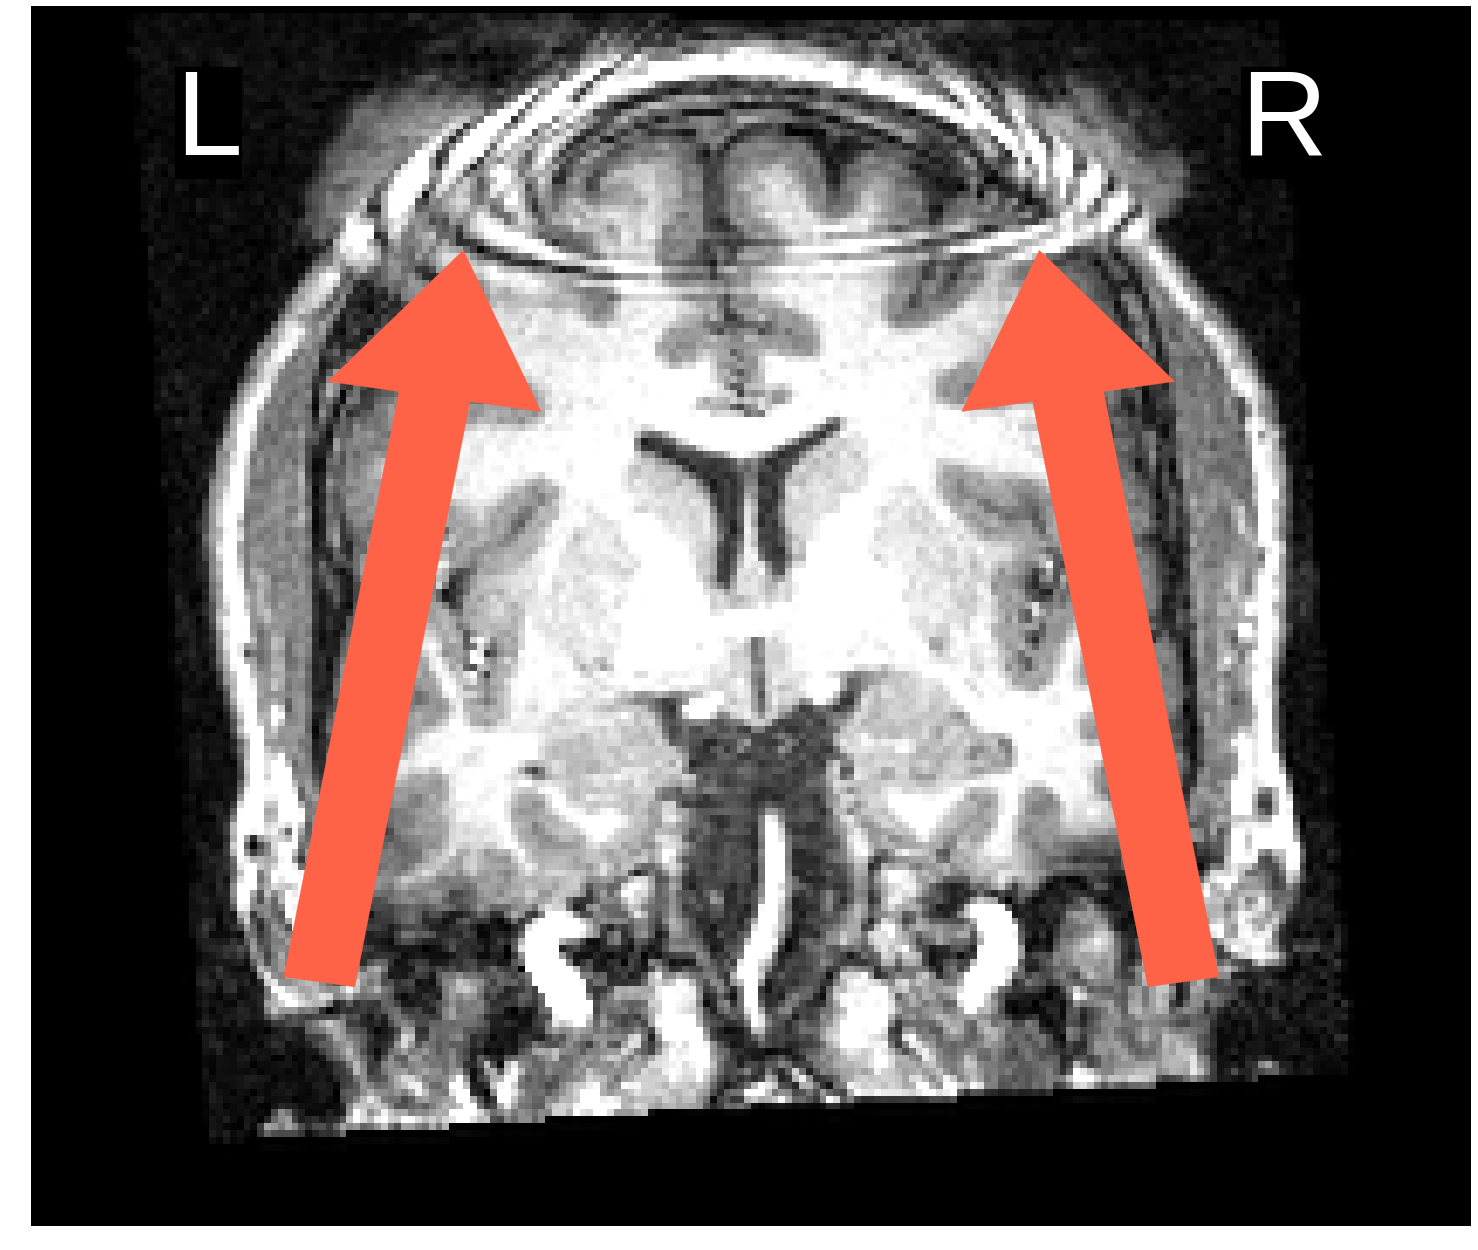

In [3]:
figure1(op.join(data_path, 'horror_gallery', 'sub-50137_T1w.nii.gz'),
        op.join(data_path, 'horror_gallery', 'sub-50110_T1w.nii.gz'),
        op.join(data_path, 'figures', 'artifacts.svg'))

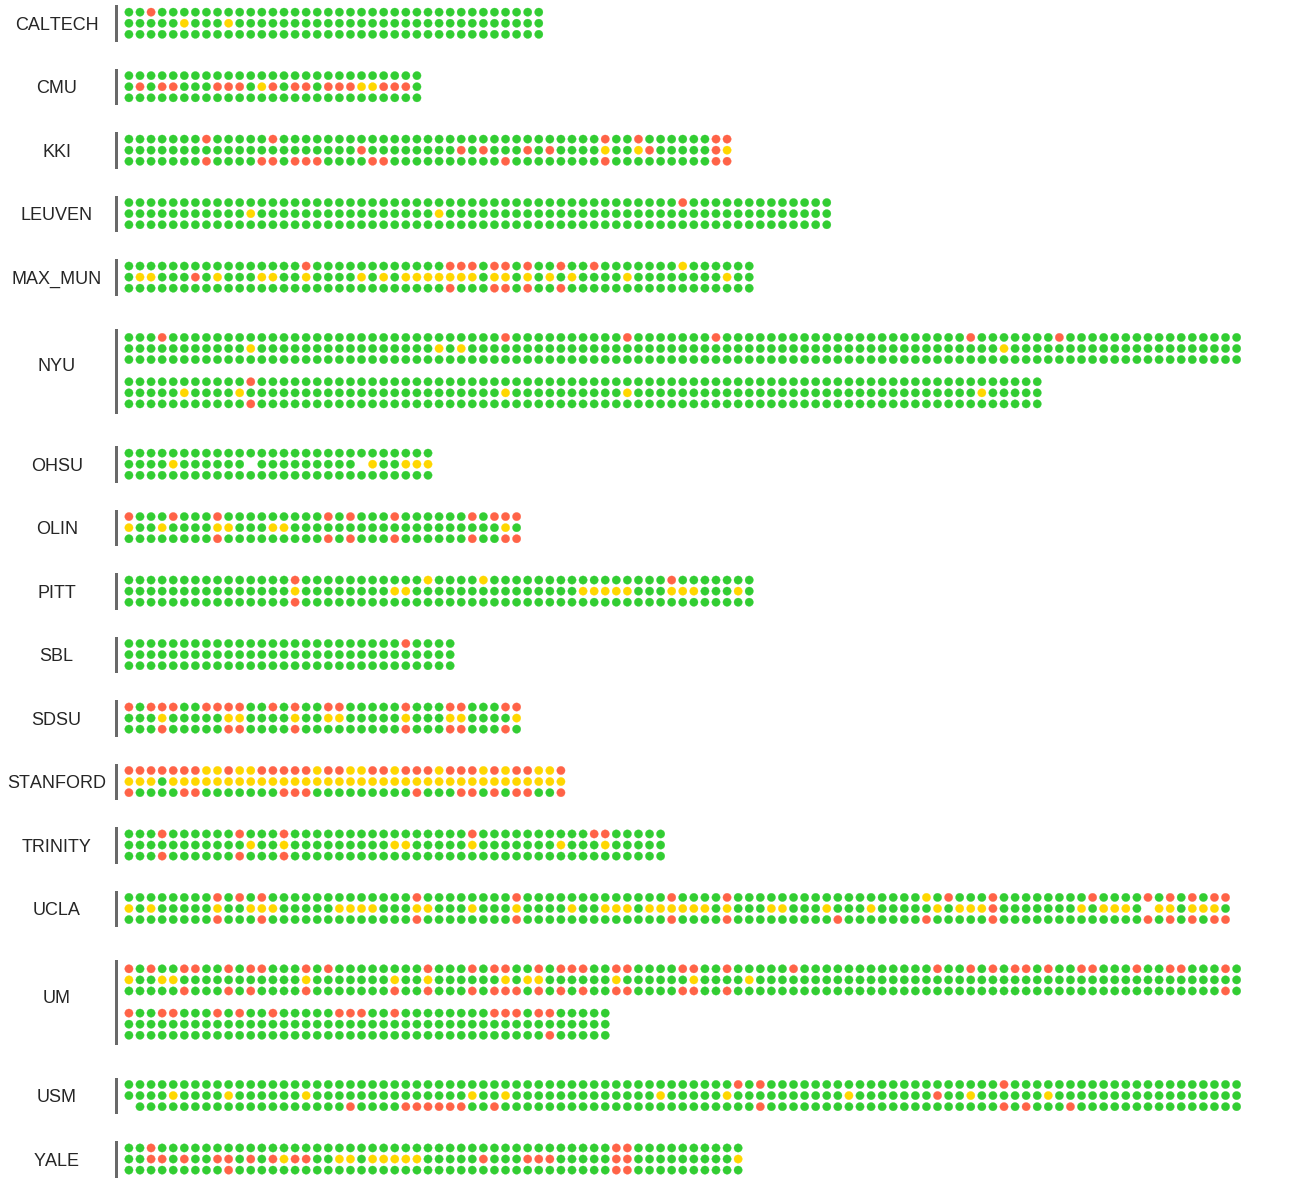

In [4]:
fig = raters_variability_plot(y_path)

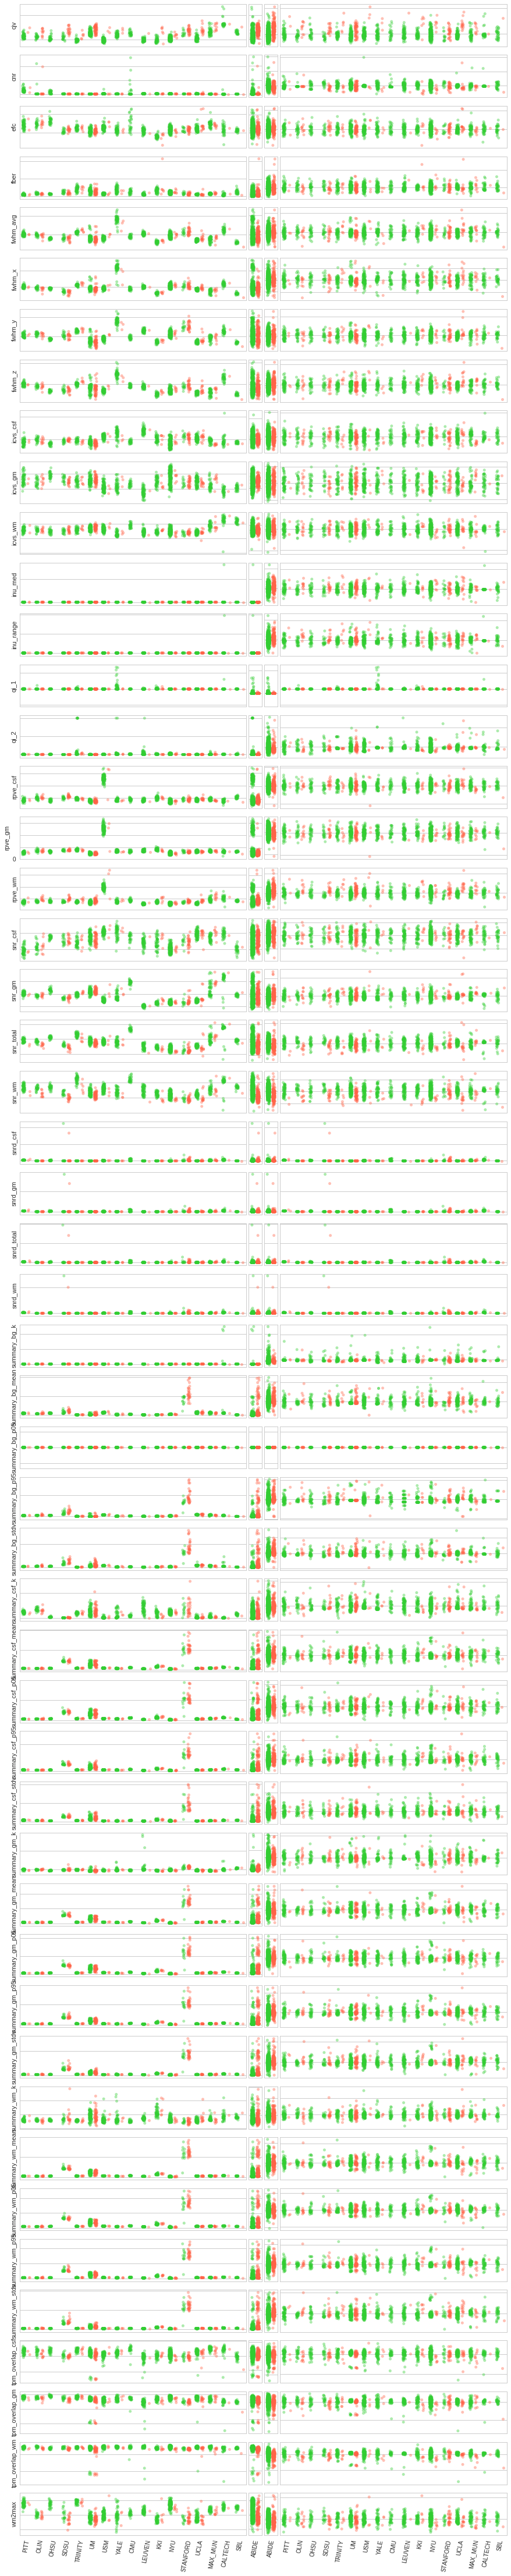

In [5]:
fig = plot_abide_stripplots(x_path, y_path)

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


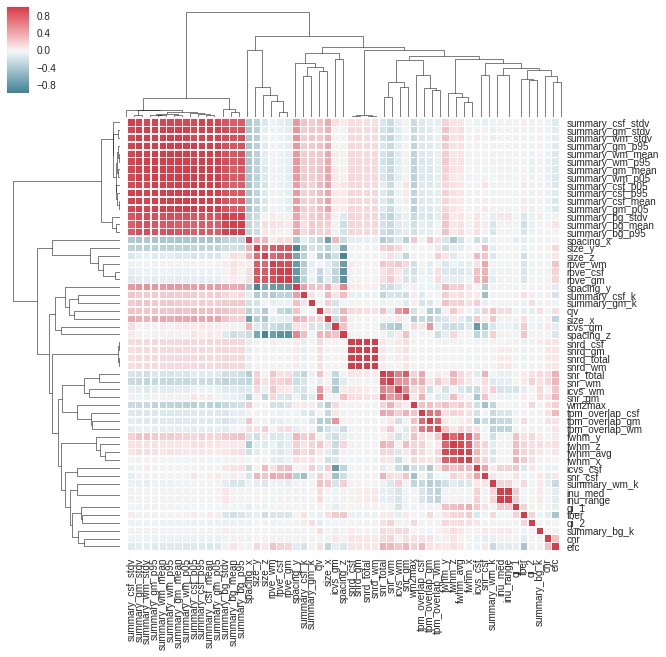

In [6]:
fig = plot_corrmat(x_path)

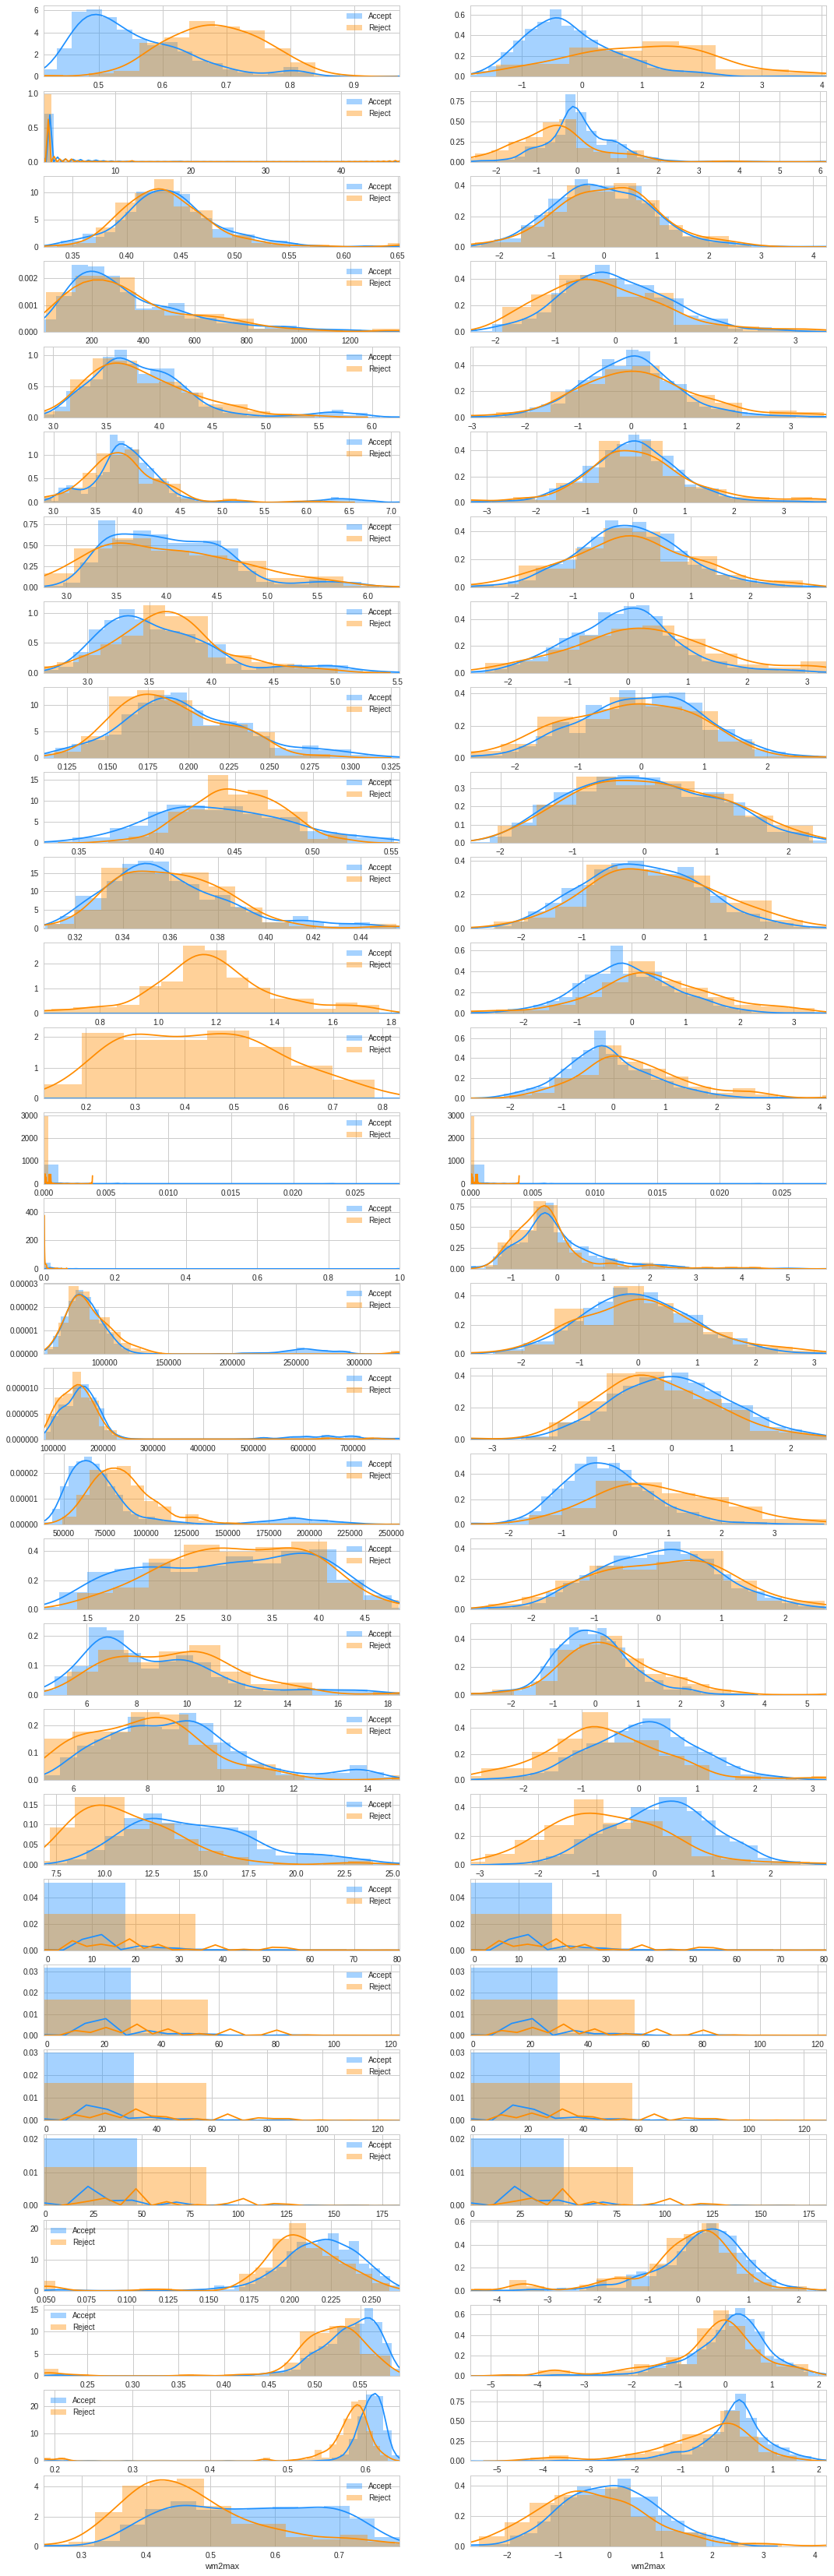

In [7]:
fig = plot_histograms(x_path, y_path)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sn

sn.set(style="whitegrid")


data_path = '/home/oesteban/Google Drive/mriqc'
loso = pd.read_csv(op.join(data_path, 'cv_loso_inner.csv'), index_col=False)
kfold = pd.read_csv(op.join(data_path, 'cv_kfold_inner.csv'), index_col=False)

kfold_outer = pd.read_csv(op.join(data_path, 'cv_kfold_outer.csv'), index_col=False)
loso_outer = pd.read_csv(op.join(data_path, 'cv_loso_outer.csv'), index_col=False)

def gen_newparams(dataframe):
    thisdf = dataframe.copy()
    thisdf['zscored_str'] = ['nzs'] * len(thisdf['zscored'])
    thisdf.loc[thisdf.zscored == 1, 'zscored_str'] = 'zs'
    thisdf['params'] = thisdf['clf'] + '-' + thisdf['zscored_str'] + ' ' + thisdf['params']
    del thisdf['zscored_str']
    return thisdf

loso = gen_newparams(loso)
kfold = gen_newparams(kfold)

In [3]:
loso_models_list = list(set(loso.params.values.ravel().tolist()))
kfold_models_list = list(set(kfold.params.values.ravel().tolist()))

best_param = {}

spstr = ['LoSo', '10-fold']
best_models = {}
for i, split_cv in enumerate([loso, kfold]):
    best_models[spstr[i]] = {}
    splitcols = [col for col in split_cv.columns.ravel() if col.startswith('split0')]
    for clf in ['svc_linear-nzs', 'svc_rbf-nzs', 'rfc-nzs', 'svc_linear-zs', 'svc_rbf-zs', 'rfc-zs']:
        thismodeldf = split_cv.loc[split_cv.params.str.contains(clf)]
        max_auc = thismodeldf.mean_auc.max()
        best = thismodeldf.loc[thismodeldf.mean_auc >= max_auc]
        best_list = best.params.values.ravel().tolist()
        
        if len(best_list) == 1:
            best_models[spstr[i]][clf] = best_list[0]
        else:
            overall_means = [thismodeldf.loc[thismodeldf.params.str.contains(pset), 'mean_auc'].mean()
                             for pset in best_list]
            overall_max = np.max(overall_means)
            if sum([val >= overall_max for val in overall_means]) == 1:
                best_models[spstr[i]][clf] = best_list[np.argmax(overall_means)]
            else:
                best_models[spstr[i]][clf] = best_list[0]
                
newdict = {'AUC': [], 'Classifier': [], 'Split scheme': []}

modelnames = {'rfc-nzs': 'RFC-nzs', 'rfc-zs': 'RFC-zs',
              'svc_linear-nzs': 'SVC_lin-nzs', 'svc_linear-zs': 'SVC_lin-zs',
              'svc_rbf-nzs': 'SVC_rbf-nzs', 'svc_rbf-zs': 'SVC_rbf-zs'}

for key, val in list(best_models['LoSo'].items()):
    scores = loso.loc[loso.params.str.contains(val), 'mean_auc'].values.ravel().tolist()
    nscores = len(scores)
   
    newdict['AUC'] += scores
    newdict['Classifier'] += [modelnames[key]] * nscores
    newdict['Split scheme'] += ['LoSo (16 folds)'] * nscores
    
for key, val in list(best_models['10-fold'].items()):
    scores = kfold.loc[kfold.params.str.contains(val), 'mean_auc'].values.ravel().tolist()
    nscores = len(scores)
   
    newdict['AUC'] += scores
    newdict['Classifier'] += [modelnames[key]] * nscores
    newdict['Split scheme'] += ['10-fold'] * nscores

newdf = pd.DataFrame(newdict).sort_values(by=['Split scheme', 'Classifier'])

In [16]:
best_models

{'10-fold': {'rfc-nzs': "rfc-nzs {'min_samples_split': 10, 'n_estimators': 10, 'max_depth': None}",
  'rfc-zs': "rfc-zs {'min_samples_split': 10, 'n_estimators': 50, 'max_depth': 10}",
  'svc_linear-nzs': "svc_linear-nzs {'C': 100}",
  'svc_linear-zs': "svc_linear-zs {'C': 0.01}",
  'svc_rbf-nzs': "svc_rbf-nzs {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}",
  'svc_rbf-zs': "svc_rbf-zs {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}"},
 'LoSo': {'rfc-nzs': "rfc-nzs {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 20}",
  'rfc-zs': "rfc-zs {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 10}",
  'svc_linear-nzs': "svc_linear-nzs {'C': 1000}",
  'svc_linear-zs': "svc_linear-zs {'C': 1000}",
  'svc_rbf-nzs': "svc_rbf-nzs {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}",
  'svc_rbf-zs': "svc_rbf-zs {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}"}}

In [4]:
def plot_cv_outer(data, score='auc', zscored=0, ax=None, ds030_score=None,
                  split_type='LoSo', color='dodgerblue'):
    
    if ax is None:
        ax = plt.gca()
            
    outer_score = data.loc[data[score].notnull(), [score, 'zscored']]
    sn.distplot(outer_score.loc[outer_score.zscored==zscored, score],
                hist=True, norm_hist=True, ax=ax, color=color, label=split_type)
    ax.set_xlim([0.4, 1.0])
    ax.grid(False)
    ax.set_yticklabels([])
    
    mean = outer_score.loc[outer_score.zscored==zscored, score].mean()
    std = outer_score.loc[outer_score.zscored==zscored, score].std()

    mean_coord = draw_line(mean, ax=ax, color=color, lw=2.0, marker='o', extend=True)
    
    ymax = ax.get_ylim()[1]
    draw_line(mean - std, ax=ax, color=color, extend=True)
    draw_line(mean + std, ax=ax, color=color, extend=True)
    
    
    ax.annotate(
        '$\mu$=%0.3f' % mean, xy=(mean_coord[0], 0.75*ymax), xytext=(-35, 30),
        textcoords='offset points', va='center', color='w', size=14,
        bbox=dict(boxstyle='round', fc=color, ec='none', color='none', lw=0),
        arrowprops=dict(
            arrowstyle='wedge,tail_width=0.8', lw=0, patchA=None, patchB=None,
            fc=color, ec='none', relpos=(0.5, 0.5)))
    sigmay = 0.70*ymax
    ax.annotate(s='', xy=(mean - std, sigmay), xytext=(mean + std, sigmay), arrowprops=dict(arrowstyle='<->'))
    ax.annotate(
        '$2\sigma$=%0.3f' % (2 * std), xy=(mean_coord[0], 0.70*ymax), xytext=(-25, -12),
        textcoords='offset points', va='center', color='k', size=12,
        bbox=dict(boxstyle='round', fc='w', ec='none', color='none', alpha=.7, lw=0))
    
    if ds030_score is not None:
        ds030_coord = draw_line(ds030_score, ax=ax, color='k', marker='o')
        ax.annotate(
            'DS030', xy=ds030_coord, xytext=(-100, 0),
            textcoords='offset points', va='center', color='w', size=16,
            bbox=dict(boxstyle='round', fc=color, ec='none', color='none', lw=0),
            arrowprops=dict(
                arrowstyle='wedge,tail_width=0.8', lw=0, patchA=None, patchB=None,
                fc=color, ec='none', relpos=(0.5, 0.5)))
        
        
def draw_line(score, ax=None, color='k', marker=None, lw=.7, extend=False):
    if ax is None:
        ax = plt.gca()
    
    if score > 1.0:
        score = 1.0
        
    coords = [score, -1]
    pdf_points = ax.lines[0].get_data()
    coords[1] = np.interp([coords[0]], pdf_points[0], pdf_points[1])
    
    if extend:
        ax.axvline(coords[0], ymin=coords[1] / ax.get_ylim()[1], ymax=0.75, color='gray', lw=.7)
    
    ax.axvline(coords[0], ymin=coords[1] / ax.get_ylim()[1], ymax=0, color=color, marker=marker, markevery=2,
                markeredgewidth=1.5, markerfacecolor='w', markeredgecolor=color, lw=lw)

    return coords

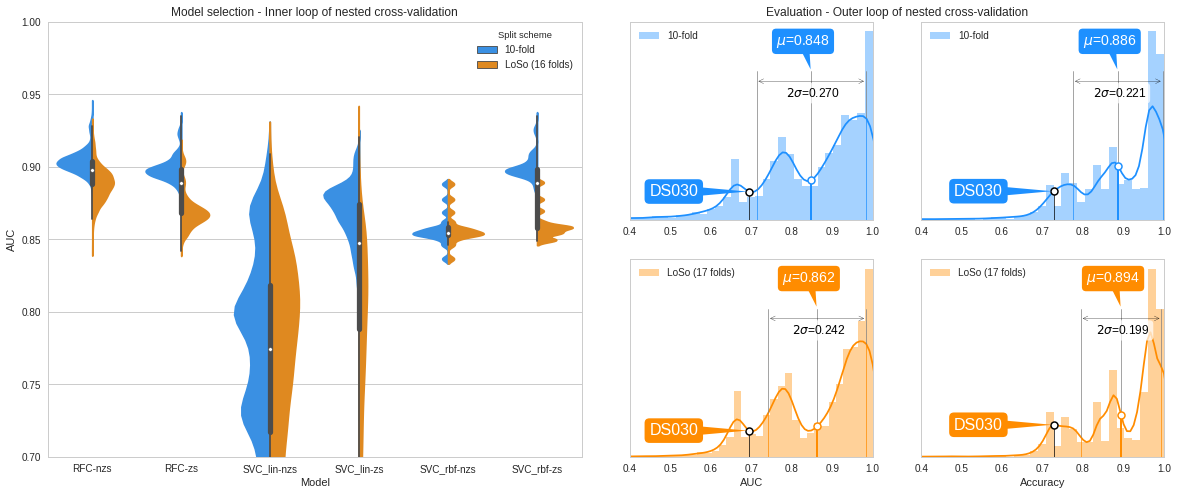

In [15]:
sn.set(style="whitegrid")

fig = plt.figure(figsize=(20, 8)) 
ax1 = plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)

sn.violinplot(x='Classifier', y='AUC', hue='Split scheme', data=newdf, split=True,
              palette=['dodgerblue', 'darkorange'], ax=ax1)
ax1.set_ylim([0.70, 1.0])
ax1.set_ylabel('AUC')
ax1.set_xlabel('Model')
ax1.set_title('Model selection - Inner loop of nested cross-validation')

ax2 = plt.subplot2grid((2,4), (0, 2))
plot_cv_outer(kfold_outer, zscored=0, score='auc', ax=ax2, ds030_score=0.695, split_type='10-fold')
ax2.set_xlabel('')
ax2.legend()
ax2.set_title('Evaluation - Outer loop of nested cross-validation')
ax2.title.set_position([1.1, 1.0])

ax3 = plt.subplot2grid((2,4), (1, 2))
plot_cv_outer(loso_outer, zscored=0, score='auc', ax=ax3, ds030_score=0.695, color='darkorange', split_type='LoSo (17 folds)')
ax3.legend()
ax3.set_xlabel('AUC')

ax4 = plt.subplot2grid((2,4), (0, 3))
plot_cv_outer(kfold_outer, zscored=0, score='acc', ax=ax4, ds030_score=0.7283, split_type='10-fold')
ax4.set_xlabel('')
ax4.legend()

ax5 = plt.subplot2grid((2,4), (1, 3))
plot_cv_outer(loso_outer, zscored=0, score='acc', ax=ax5, ds030_score=0.7283, color='darkorange', split_type='LoSo (17 folds)')
ax5.legend()
ax5.set_xlabel('Accuracy')


fig.savefig(op.expanduser('~/Dropbox/My Publications/2017-MRIQC/figures/crossvalidation.pdf'),
            bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
zscoreddf = loso_outer.loc[loso_outer.zscored == 0, ['auc', 'acc', 'site']]
palette = sn.color_palette("cubehelix", len(set(zscoreddf.site)))
sn.pairplot(zscoreddf.loc[zscoreddf.auc.notnull(), ['auc', 'acc', 'site']], hue='site', palette=palette)

(0.5, 1.0)

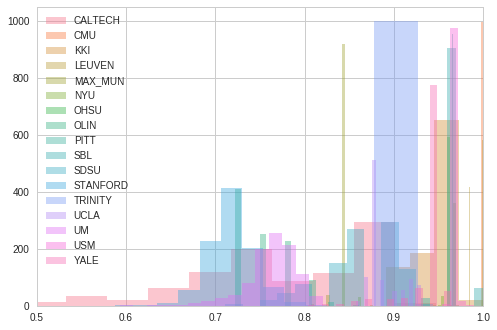

In [19]:
sites = sorted(list(set(loso_outer.site.ravel().tolist())))
palette = sn.color_palette("husl", len(sites))
fig = plt.figure()
for i, site in enumerate(sites):
    sitedf = loso_outer.loc[loso_outer.site == site]
    accdf = sitedf.loc[sitedf.zscored==0]
    sn.distplot(accdf.acc.values.ravel(), bins=20, kde=0, label=site, color=palette[i])

fig.gca().legend()
fig.gca().set_xlim([0.5, 1.0])

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import matplotlib.pyplot as plt
from pkg_resources import resource_filename as pkgrf
from os.path import splitext
from sklearn.externals.joblib import load as loadpkl
import numpy as np
import seaborn as sn
import pandas as pd

estimator = loadpkl(pkgrf('mriqc', 'data/rfc-nzs-abide-1.0.pklz'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


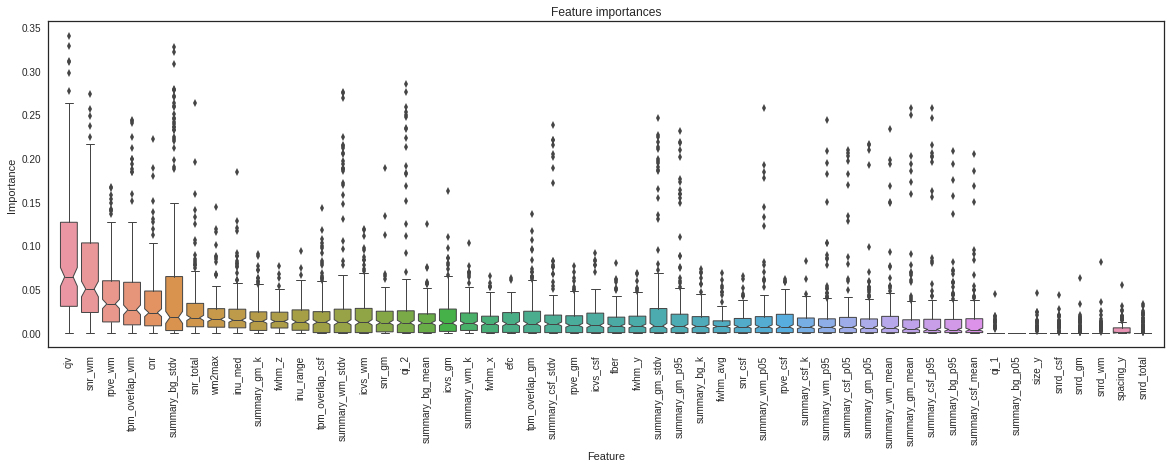

In [24]:
sn.set_style("white")
features = estimator._ftnames
nft = len(features)

forest = estimator.best_estimator_
importances = np.median([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
# importances = np.median(, axis=0)
indices = np.argsort(importances)[::-1]

df = {'Feature': [], 'Importance': []}
for tree in forest.estimators_:
    for i in indices:
        df['Feature'] += [features[i]]
        df['Importance'] += [tree.feature_importances_[i]]
fig = plt.figure(figsize=(20, 6))
plt.title("Feature importances")
sn.boxplot(x='Feature', y='Importance', data=pd.DataFrame(df), linewidth=1, notch=True)
# plt.bar(range(nft), importances[indices],
#        color="r", yerr=std[indices], align="center")
plt.xticks(range(nft))
plt.gca().set_xticklabels([features[i] for i in indices], rotation=90)
plt.xlim([-1, nft])
plt.show()
fig.savefig(op.expanduser('~/Dropbox/My Publications/2017-MRIQC/figures/feature_importance.pdf'),
            bbox_inches='tight', pad_inches=0, dpi=300)